In [1]:
!python --version
!pip install --upgrade networkx==1.9.1
!pip show networkx
!pip install numpy numba matplotlib
!pip install ConfigModel_MCMC

Python 3.9.13
  Using cached networkx-1.9.1-py2.py3-none-any.whl (1.2 MB)
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
configmodel-mcmc 0.1.1 requires networkx==3.1, but you have networkx 1.9.1 which is incompatible.
You should consider upgrading via the 'C:\Users\gamer\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


Name: networkx
Version: 1.9.1
Summary: Python package for creating and manipulating graphs and networks
Home-page: http://networkx.github.io/
Author: NetworkX Developers
Author-email: networkx-discuss@googlegroups.com
License: BSD
Location: c:\users\gamer\appdata\local\packages\pythonsoftwarefoundation.python.3.9_qbz5n2kfra8p0\localcache\local-packages\python39\site-packages
Requires: decorator
Required-by: ConfigModel_MCMC, torch


You should consider upgrading via the 'C:\Users\gamer\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: networkx
    Found existing installation: networkx 1.9.1
    Uninstalling networkx-1.9.1:
      Successfully uninstalled networkx-1.9.1


You should consider upgrading via the 'C:\Users\gamer\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
import numba
import ConfigModel_MCMC as CM
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import networkx as nx
import numpy as np
import os
import random
import igraph as ig
import pandas as pd
import statistics as stats
import time
import math
import copy
from networkx.algorithms import bipartite
import threading
import concurrent.futures as tpool
import copy

In [3]:
def load_graph(edgelist_file, meta_file):
    #load the data from file
    filename = os.path.join(os.fsdecode(meta_file))
    print(filename)
    file = open(filename,"r")
    meta = pd.read_csv(filename,names=["node","name","type","bipartite"], sep=" ")
    file.close()

    #read nodes with metadata into graph
    G = nx.empty_graph()
    meta = meta.sort_values(by=['node'])
    titles = {}
    for row in meta.iloc:
        G.add_node(row[0], name=row[1], type=row[2], bipartite=row[3])
        if(row[2] == 'Work'):
            titles.update({row[1]:row[0]})
    print(G.number_of_nodes())

    #load and apply edges
    filename = os.path.join(os.fsdecode(edgelist_file))
    print(filename)
    file = open(filename,"r")
    Ge = nx.parse_edgelist(file, None).edges()
    file.close() 
    for e in Ge:
        G.add_edge(int(e[0]),int(e[1]))
    print(G.number_of_edges())
    print("Graph loaded")

    # I hate that the source data is formatted this way, 
    # but the way works are distinguished from tropes 
    # is that works either don't have a main page
    # or works have a duplicate node for the main page with '/int_name' at the end
    # unless the main page is deprecated, which leaves no visible difference in the data
    # categories, noted authors, and other non-trope non-work pages are never distinguished from tropes
    # this data is rather messy, but hopefully there won't be enough noise to throw off the algorithms too much
    #merge duplicate work nodes
    to_remove = []
    for n, data in G.nodes(data=True):
        if(data['name']+'/int_name' in titles.keys()):
            u = titles[data['name']+'/int_name']
            for e in G.edges(n):
                if(e[0] == n and e[1] != u):
                    G.add_edge(u,e[1])
                elif(e[1] == n and e[0] != u):
                    G.add_edge(e[0],u)
            to_remove.append(n)
    G.remove_nodes_from(to_remove)

    #remove nodes with too few degrees as they are likely deprecated
    to_remove = []
    for n in G.nodes():
        if(G.degree(n) <= 1):
            to_remove.append(n)
    G.remove_nodes_from(to_remove)
    
    print("Graph processed")
    return G

oG = load_graph("../NetworksHW1/TVTropes/dbtropes-edgelist.txt", "../NetworksHW1/TVTropes/dbtropes-meta.txt")
top, bottom = bipartite.sets(oG)
print("Number of nodes: "+str(oG.number_of_nodes()))
print("Left: "+str(len(top)))
print("Right: "+str(len(bottom)))
print("Number of edges: "+str(oG.number_of_edges()))


../NetworksHW1/TVTropes/dbtropes-meta.txt
152093
../NetworksHW1/TVTropes/dbtropes-edgelist.txt
3232134
Graph loaded
Graph processed
Number of nodes: 74247
Left: 25118
Right: 49129
Number of edges: 3165969


In [4]:
def valid_neighbors(n,G,trope):
    valid_neighbors = []
    problems = 0
    for node in G.neighbors(n):
        if(trope == (G.nodes[node]['type'] == "Trope")):
            G.nodes[node]['group'] = G.nodes[n]['group']
            valid_neighbors.append(node)
        else:
            problems+=1
    if(problems > len(valid_neighbors)):
        print("["+str(problems)+" problems]",end=" ")
        return None
    return valid_neighbors

def sample_from_type(G,num,start_type):
    samp = []
    samp += random.sample(G.nodes, num)
    for i in range(0,num):
        while(G.nodes[samp[i]]['type'] != start_type):
            samp[i] = random.sample(G.nodes,1)[0]
    return samp

def print_random_sample(G,num):
    samp = []
    samp += random.sample(G.nodes, num)
    for s in samp:
        print(G.nodes[s])

def union(A,B):
    return list(set(A) | set(B))

def intersection(A,B):
    return list(set(A) & set(B))

def setSubtract(A,B):
    return list(set(A) - set(B))


In [19]:
def bipartite_sampler(init_G,start_type,points):
    G = copy.deepcopy(init_G)
    T = []
    t = []
    W = []
    init_sample = sample_from_type(G,points,start_type)
    counter = 1
    for i in init_sample:
        G.nodes[i]['group'] = [counter]
        counter+=1
    W += init_sample
    w = W
    for node in w:
        print(G.nodes[node],end=", ")
    for i in range(0,1):
        t = []
        for node in w:
            v = valid_neighbors(node,G,True)
            if(v is None):
                w.remove(node)
            else:
                v = setSubtract(setSubtract(v,T),W)
                t = union(t,v)
        W = union(w,W)
        t = setSubtract(t,T)
        print("t-ropes = "+str(len(t)))
        print("W-orks = "+str(len(W)))
        w = []
        for node in t:
            v = valid_neighbors(node,G,False)
            if(v is None):
                t.remove(node)
            else:
                v = setSubtract(setSubtract(v,T),W)
                w = union(w,v)
        T = union(t,T)
        w = setSubtract(w,W)
        print("w-orks = "+str(len(w)))
        print("T-ropes = "+str(len(T)))
        print("layer "+str(i)+" done")
        print("this must be zero: "+str(len(intersection(W,T))))
    W_all = union(w,W)
    print("this must be zero: "+str(len(intersection(W,T))))
    orig = G.nodes()
    G.remove_nodes_from(setSubtract(orig,union(W_all,T)))
    G.remove_nodes_from(init_sample)
    print(str(len(G.nodes))+" should equal "+str(len(union(W_all,T))))
    top, bottom = bipartite.sets(G)
    print(len(top))
    print(len(bottom))
    zeroes = random.sample(G.nodes, 50)
    for z in zeroes:
        G.nodes[z]['group'] = [0]
    print("Done")
    print("sampled "+str(G.number_of_nodes())+" nodes out of "+str(init_G.number_of_nodes())+" nodes")
    print("sampled "+str(G.number_of_edges())+" edges out of "+str(init_G.number_of_edges())+" edges")
    return G

groups = 20
G = bipartite_sampler(oG,'Work',20)
for i in random.sample(G.nodes, 20):
    print(G.nodes[i])
    

C:\Users\gamer\AppData\Local\Temp\ipykernel_27456\366199479.py:17: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  samp += random.sample(G.nodes, num)
C:\Users\gamer\AppData\Local\Temp\ipykernel_27456\366199479.py:20: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  samp[i] = random.sample(G.nodes,1)[0]


{'name': 'Film/ILoveYouMan/int_name', 'type': 'Work', 'bipartite': 1, 'group': [1]}, {'name': 'VideoGame/GoldenLand/int_name', 'type': 'Work', 'bipartite': 1, 'group': [2]}, {'name': 'Film/AlmostFamous/int_name', 'type': 'Work', 'bipartite': 1, 'group': [3]}, {'name': 'Literature/ZoneOne/int_name', 'type': 'Work', 'bipartite': 1, 'group': [4]}, {'name': 'VideoGame/BlackRockShooter/int_name', 'type': 'Work', 'bipartite': 1, 'group': [5]}, {'name': 'Music/TheKinksAreTheVillageGreenPreservationSociety/int_name', 'type': 'Work', 'bipartite': 1, 'group': [6]}, {'name': 'WesternAnimation/MissionMagic/int_name', 'type': 'Work', 'bipartite': 1, 'group': [7]}, {'name': 'Anime/PersonaTrinitySoul/int_name', 'type': 'Work', 'bipartite': 1, 'group': [8]}, {'name': 'Main/MegaManPoweredUp/int_name', 'type': 'Work', 'bipartite': 1, 'group': [9]}, {'name': 'Main/LaFemmeNikita/int_name', 'type': 'Work', 'bipartite': 1, 'group': [10]}, {'name': 'Film/KillerElite/int_name', 'type': 'Work', 'bipartite': 1,

C:\Users\gamer\AppData\Local\Temp\ipykernel_27456\2023746474.py:51: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  zeroes = random.sample(G.nodes, 50)
C:\Users\gamer\AppData\Local\Temp\ipykernel_27456\2023746474.py:61: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  for i in random.sample(G.nodes, 20):


In [20]:
def trope_projection(G):
    top_nodes, bottom_nodes = bipartite.sets(G)
    BP = bipartite.weighted_projected_graph(G,top_nodes)
    return BP

In [21]:
def get_groups(G):
    z = {}
    for n in G.nodes():
        z.update({n:G.nodes[n]['group']})
    return z

def randomize_groups(G,c):
    for node in G.nodes():
        G.nodes[node]['group'] = [random.randint(0,c)]
    return G

In [22]:
def save_gml(filename, G):
    sampleFile = open(filename, "w")
    i = 0
    sampleFile.write("graph [\n")
    for n, data in G.nodes(data=True):
        sampleFile.write("    node [\n")
        sampleFile.write("        id "+str(n)+"\n")
        sampleFile.write("        label "+str(n)+"\n")
        sampleFile.write("        name \""+data['name']+"\"\n")
        sampleFile.write("        type \""+data['type']+"\"\n")
        sampleFile.write("        bipartite "+str(data['bipartite'])+"\n")
        sampleFile.write("        group "+str(data['group'])+"\n")
        sampleFile.write("    ]\n")
        i += 1
    for u, v, data in G.edges(data=True):
        sampleFile.write("    edge [\n")
        sampleFile.write("        source "+str(u)+"\n")
        sampleFile.write("        target "+str(v)+"\n")
        sampleFile.write("        name \""+str(data['weight'])+"\"\n")
        sampleFile.write("    ]\n")
    sampleFile.write("]\n")
    sampleFile.close()

def load_gml(filename):
    sample = nx.read_gml(filename)
    return sample

def fix_values(G):
    for n, data in G.nodes(data=True):
        #G.nodes[n]['label'] = data['name']
        G.nodes[n]['bipartite'] = str(data['bipartite'])
        G.nodes[n]['group'] = str(data['group'])
        #print(G.nodes[n])

In [23]:
print("projecting")
B = trope_projection(G)
print("projected")
p = B.number_of_edges()/B.number_of_nodes()
cc = nx.average_clustering(B)
print("clustering calculated")
for i, data in B.nodes(data=True):
    if(len(data['group']) > 1):
        print(str(i)+": "+str(data['group']))
print("Average Degree: "+str(p))
print("Clustering Coefficient: "+str(cc))

projecting
projected
clustering calculated
Average Degree: 312.44
Clustering Coefficient: 0.9230697931461854


In [24]:
#0 exception updated
def nodes_in_groups(G,c):
    nodes = []
    for i in range(0,c+1):
        nodes.append([])
    for n in G.nodes:
        com = G.nodes[n]['group']
        for C in com:
            try:
                nodes[C].append(n)
            except:
                print("error "+str(C)+" not valid community")
    return nodes

def log_likelihood_no_generic(oG,c):
    G = copy.deepcopy(oG)
    toRemove = []
    for i in G.nodes:
        if(0 in G.nodes[i]['group']):
            toRemove.append(i)
    G.remove_nodes_from(toRemove)
    e = [[0]*(c+1) for i in range(c+1)]
    n = [[0]*(c+1) for i in range(c+1)]
    nodes = nodes_in_groups(G,c)
    for u,v in G.edges():
        for r in G.nodes[u]['group']:
            for s in G.nodes[v]['group']:
                e[r][s] += 1
                e[s][r] += 1
    out = 0
    for i in range(0,c+1):
        for j in range(0,c+1):
            n[i][j] = len(nodes[i])*len(nodes[j])
            n[j][i] = len(nodes[i])*len(nodes[j])
            if(n[i][j] != 0 and e[i][j] != 0 and n[i][j] > e[i][j]):
                out += e[i][j] * math.log(e[i][j]/n[i][j]) + (n[i][j]-e[i][j]) * math.log(float(n[i][j]-e[i][j])/n[i][j])
    print("Log-Likelihood = "+str(out))
    return out

def log_likelihood(G,c):
    e = [[0]*(c+1) for i in range(c+1)]
    n = [[0]*(c+1) for i in range(c+1)]
    nodes = nodes_in_groups(G,c)
    for u,v in G.edges():
        for r in G.nodes[u]['group']:
            for s in G.nodes[v]['group']:
                e[r][s] += 1
                e[s][r] += 1
    out = 0
    for i in range(0,c+1):
        for j in range(0,c+1):
            n[i][j] = len(nodes[i])*len(nodes[j])
            n[j][i] = len(nodes[i])*len(nodes[j])
            if(n[i][j] != 0 and e[i][j] != 0 and n[i][j] > e[i][j]):
                out += e[i][j] * math.log(e[i][j]/n[i][j]) + (n[i][j]-e[i][j]) * math.log(float(n[i][j]-e[i][j])/n[i][j])
    print("Log-Likelihood = "+str(out))
    return out


def WCC(G,n,C,S):
    txC, txV, vtxV, vtxVC = WCCTriangles(G,n,C)
    try:
        return ((txC/txV)*(vtxV/((S-1)+vtxVC)))
    except:
        return 0

#0 exception updated
def WCCTriangles(G,n,C):
    txC = 0
    txV = 0
    vtxV = 0
    vtxVC = 0
    for j in G.neighbors(n):
        tri = False
        jC = C in G.nodes[j]['group']
        if(jC != 0):
            for k in G.neighbors(n):
                if G.has_edge(j,k):
                    kC = C in G.nodes[k]['group']
                    if(kC != 0):
                        tri = True
                        txV += 1
                        if(jC and kC or jC*kC == 0):
                            txC += 1
            if(tri):
                vtxV += 1
                if(not jC):
                    vtxVC += 1
    txC /= 2
    txV /= 2
    return txC, txV, vtxV, vtxVC 

def WCCP(oG,c):
    G = copy.deepcopy(oG)
    toRemove = []
    sum = 0
    for i in G.nodes:
        if(0 in G.nodes[i]['group']):
            sum += .95
            toRemove.append(i)
    G.remove_nodes_from(toRemove)
    coms = nodes_in_groups(G,c)
    penalty = 0
    for C in range(0,c+1):
        S = len(coms[C])
        for n in coms[C]:
            sum += WCC(G,n,C,S)
            penalty += .1*pow(len(G.nodes[n]['group'])-1,2)
    print("WCC = "+str(sum))
    print("Modified WCC = "+str(sum-penalty))
    return sum, sum-penalty
            


In [25]:
def delta_leave(G,n,C,p,cc,degree,di,wc,node_group):
    try:
    #initialize all base values
        pi, q, S = data_fetches(G,C,node_group)
        do = degree-di
        M = S
        N = di
        M -= N
        pe = cc
    #calculate compound values
        delta_a = (((di-1)*pi) / (.5*(S-1)*(S-2)*pow(pi,3) + (di-1)*pi + q*(S-1)*pi*pe + .5*S*(S-1)*pe + do*pe)) * (((S-1)*pi + 1 + q)/(S+q))
        delta_b = ((.5*(S-1)*(S-2)*pow(pi,3)) / ((.5*(S-1)*(S-2)*pow(pi,3)) + q*(q-1)*pe + q*(S-1)*pi*pe)) * (((S-1)*pi + q) / ((S+q)*(S-1+q)))
        wcc = (((di*(di-1)*pi)*(di+do)) / ((di*(di-1)*pi) + (do*(do-1)*pe))) * (1/(S+do))
    except:
        return 0
    #print(".",end="")
    return (wc*(N*delta_a+M*delta_b)-wc*wcc)

#0 exception updated
def delta_leave_mod(G,n,C,p,cc,degree,di,wc,node_group,total_communities,adjacent_communities):
    if(C != 0):
        #from the outside, treat group 0 as not a member of V
        try:
        #initialize all base values
            pi, q, S = data_fetches(G,C,node_group)
            do = degree-di
            M = S
            N = di
            M -= N
            pe = cc
        #calculate compound values
            delta_a = (((di-1)*pi) / (.5*(S-1)*(S-2)*pow(pi,3) + (di-1)*pi + q*(S-1)*pi*pe + .5*S*(S-1)*pe + do*pe)) * (((S-1)*pi + 1 + q)/(S+q))
            delta_b = ((.5*(S-1)*(S-2)*pow(pi,3)) / ((.5*(S-1)*(S-2)*pow(pi,3)) + q*(q-1)*pe + q*(S-1)*pi*pe)) * (((S-1)*pi + q) / ((S+q)*(S-1+q)))
            wcc = (((di*(di-1)*pi)*(di+do)) / ((di*(di-1)*pi) + (do*(do-1)*pe))) * (1/(S+do))
        except:
            return 0
        #print(".",end="")
        com_num = len(G.nodes[n]['group'])
        return (wc*(N*delta_a+M*delta_b)-wc*wcc) - .1*pow(com_num-1,2)
    else:
        #if C = 0, treat all groups as part of group C and add a normalization penalty equal to the number of groups plus the number of groups 
        try:
        #initialize all base values
            di = degree
            do = 0
            pi = p
            pe = cc
            q = 0
            S = G.number_of_nodes()-1
            M = S
            N = di
            M -= N
            pe = cc
        #calculate compound values
            delta_a = (((di-1)*pi) / (.5*(S-1)*(S-2)*pow(pi,3) + (di-1)*pi + .5*S*(S-1)*pe)) * (((S-1)*pi + 1)/S)
            delta_b = (pi / S)
            wcc = 1
        except:
            return 0
        com_num = 1
        return (wc*(N*delta_a+M*delta_b)-wc*wcc) - .1*pow(com_num-1,2) 
        

#0 exception not needed
def FOX(G,n,c,p,cc):
    max = 0
    transfer = 0
    degree = G.degree(n)
    dis, wcs, communities = degree_across_groups(G,n,c)
    node_groups = nodes_in_groups(G,c)
    for C in G.nodes[n]['group']:
        delta_L = delta_leave_mod(G,n,C,p,cc,degree,dis[C]+dis[0],wcs[C],node_groups[C],c,len(communities))
        if(delta_L > 0):
            G.nodes[n]['group'].remove(C)
    for C in communities:
        delta_add_to = -1*delta_leave_mod(G,n,C,p,cc,degree,dis[C]+dis[0],wcs[C],node_groups[C],c,len(communities))
        if(delta_add_to > max):
            max = delta_add_to
            transfer = C
    if(transfer not in G.nodes[n]['group']):
        print(";",end="")
        if(0 in G.nodes[n]['group']):
            G.nodes[n]['group'] = []
        G.nodes[n]['group'].append(transfer)
    else:   
        print("|",end="")
    if(0 in G.nodes[n]['group']):
            G.nodes[n]['group'] = [0]

#0 exception updated
def degree_across_groups(G,n,c):
    degs = []
    weights = []
    coms = copy.deepcopy(G.nodes[n]['group'])
    coms.append(0)
    for i in range(0,(c+1)):
        degs.append(0)
        weights.append(0)
    for node in G.neighbors(n):
        com = G.nodes[node]['group']
        for C in com:
            weights[C] += G[n][node]['weight']
            degs[C] += 1
            if(C not in coms):
                coms.append(C)
    for i in range(0,c+1):
        if(degs[i] > 0):
            weights[i] /= degs[i]
    return degs, weights, coms

#0 exception added
def data_fetches(G,C,nodes):
    if(len(nodes) == 0):
        return 0
    edges = G.edges(nodes)
    q_edge = 0
    for u, v in edges:
        if(((C not in G.nodes[u]['group']) or (C not in G.nodes[v]['group']))):
            q_edge += 1
    q = q_edge/len(nodes)
    S = len(nodes)-1
    if(len(nodes) == 1):
        return 0, q, S
    pi = len(edges)/(pow(len(nodes),2)-len(nodes))
    return pi, q, S

#0 exception not needed
def display_summary_of_group(G,c,C):
    group = nodes_in_groups(G,c)[C]
    degrees = {}
    for n in group:
        degrees.update({n:G.degree(n)})
    sorted_degrees = sorted(degrees.items(), key=lambda x:x[1])
    print("GROUP "+str(C)+" - "+str(len(group))+" tropes")
    for i in range(0,min(8,len(group))):
        print(str(i+1)+": "+G.nodes[sorted_degrees[i][0]]['name'])
    if(len(group) >= 8):
        print("and a random selection of other nodes")
        samp = []
        samp += random.sample(group, min(16,len(group)-8))
        for s in samp:
            print("-"+G.nodes[s]['name'])
    print("")

def FOX_iteration(G,c,p,cc,count):
    print("iter "+str(count)+":")
    for n in G.nodes:
        FOX(G,n,c,p,cc)
    print("")
    wcc, wccm = WCCP(G,c)
    ll = log_likelihood(G,c)
    llng = log_likelihood_no_generic(G,c)
    return wcc, wccm, ll, llng

def fullExperiment(G,c,max_runs,p=-1,cc=-1):
    #check inputs
    if(p < 0):
        p = G.number_of_edges()/G.number_of_nodes()
    if(cc < 0):
        cc = nx.average_clustering(G)
    #set up plot
    figure, axis = plt.subplots(2)
    axis[0].set_title("WCC metrics")
    axis[1].set_title("Log-Likelihood")
    palette = [['deepskyblue','mediumblue'],['red', 'firebrick'],['lime','green']]
    GBest = None
    bestWCC = 0
    for trial in range(0,3):
    #randomize and try again
        randomize_groups(G,c)
        print("")
        plotRuns = [0]
        wcc, wccm = WCCP(G,c)
        wccs = [wcc]
        wccms = [wccm]
        lls = [log_likelihood(G,c)]
        llngs = [log_likelihood_no_generic(G,c)]
        for i in range(1,max_runs+1):
            wcc, wccm, ll, llng = FOX_iteration(G,c,p,cc,i)
            wccs.append(wcc)
            wccms.append(wccm)
            lls.append(ll)
            llngs.append(llng)
            plotRuns.append(i)
            if(wccms[i] == wccms[i-1] and wccms[i] == wccms[i-2]):
                break
        axis[0].plot(plotRuns,wccms,color=palette[trial][0])
        axis[0].plot(plotRuns,wccs,color=palette[trial][1])
        axis[1].plot(plotRuns,llngs,color=palette[trial][0])
        axis[1].plot(plotRuns,lls,color=palette[trial][1])
        for i in range(0,groups):
            display_summary_of_group(B,groups,i)
        save_gml("../NetworksHW1/TVTropes/results"+str(trial)+".gml",G)
        if(wccs[len(wccs)-1] > bestWCC):
            GBest = copy.deepcopy(G)
            bestWCC = wccs[len(wccs)-1]
    return GBest


WCC = 628.3036557481596
Modified WCC = 628.3036557481596
Log-Likelihood = -208142.38784745094
Log-Likelihood = -190432.48086167808
iter 1:
|;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;|;;;;;;;;;;;;;;;;;;;;;;|;;;;;;;;;;;;;;;;;;;;|;|;;;;;;;;;;;;|;;|;;;;;;;;;;;;;;;;;;;|;|;;;;|;;;;;;;|;;;;;;;;;;;;|;;;;;;;;;;;;;;;;;;;;;;;;;;;;;|;;;;;;;;;;;|;;;;;;;;;;;;;;;;;;;;;;;;;;;;|;;;;;|;;;;;;;;;;;;;;;;;;;;;;|;;;;;|;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;|;;;;;;|;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;|;;;;;;;;;;;;;;;;|;;;;;|;|;;;;;;;;;;;;;|;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;|;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;|;;;;;;;;;;;;;;;;;|;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;|;;;;;;;;;;;;;;;;;|;;;;;|;;;;;;;;|;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;|;;;;;;;;;|;;;;;;;;;|;;;;;;;;;;|
WCC = 1219.5001850855074
Modified WCC = 1090.1001850855105
Log-Likelihood = -725641.3400525386
Log-Likelihood = -725590.028268111
iter

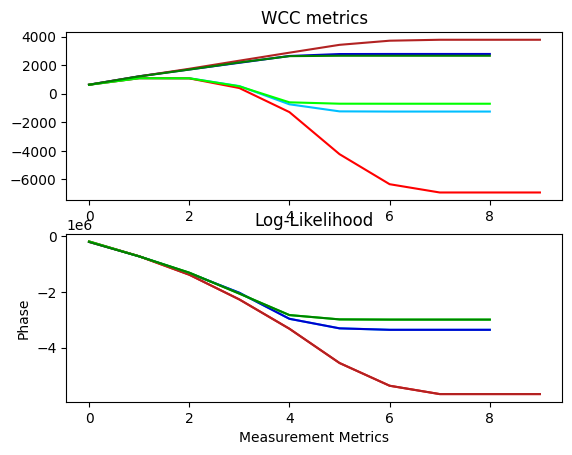

In [26]:
max_runs = 10
out = fullExperiment(B,groups,max_runs,p,cc)
plt.xlabel("Measurement Metrics")
plt.ylabel("Phase")
plt.show()

In [40]:
plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 400

||||||
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

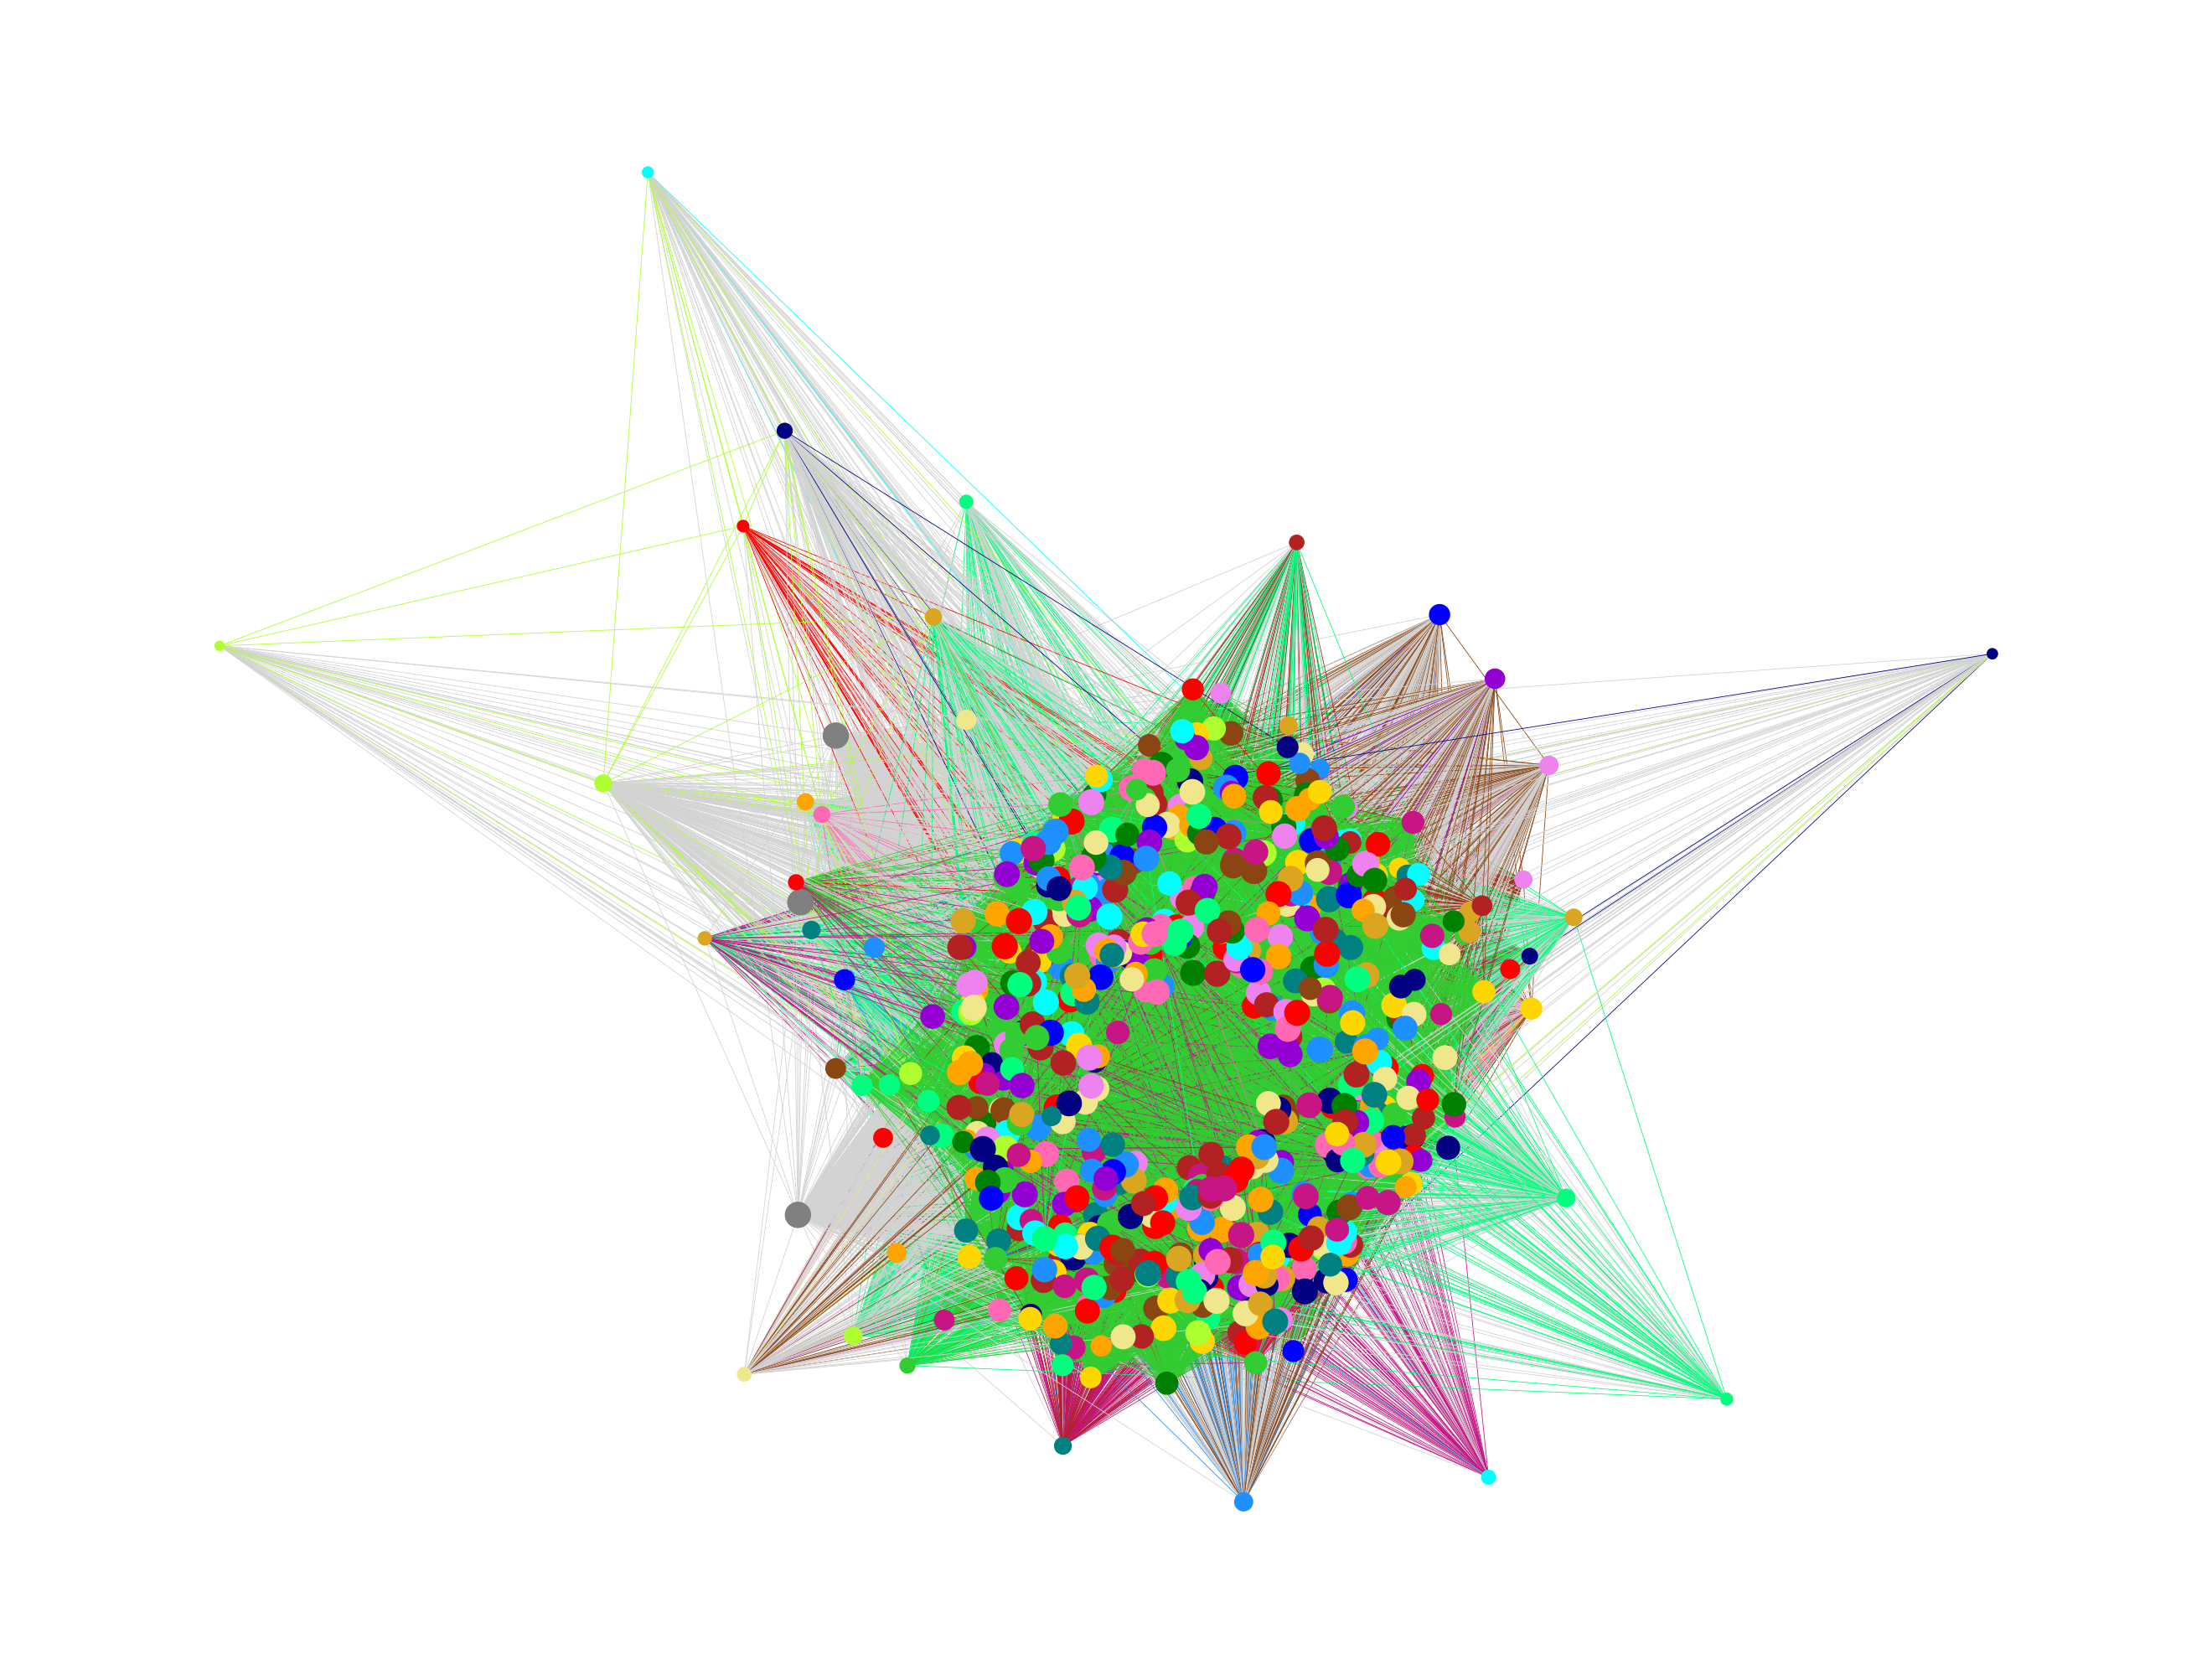

In [41]:
colors = []
sizes = []
color_table = ['gray','red','firebrick','orange','saddlebrown','khaki','gold','goldenrod','greenyellow','limegreen','green','springgreen','cyan','teal','dodgerblue','blue','navy','darkviolet','violet','hotpink','mediumvioletred','pink']
edge_color_table = ['lightgray','red','firebrick','orange','saddlebrown','khaki','gold','goldenrod','greenyellow','limegreen','green','springgreen','cyan','teal','dodgerblue','blue','navy','darkviolet','violet','hotpink','mediumvioletred','pink']
for node, data in B.nodes(data=True):
    data['group'].sort
    sizes.append(B.degree[node]*.03)
    colors.append(color_table[data['group'][0]])
    if((int(node) % 100) == 0):
        print("|",end="")
print("")
weights = []
edge_cols = []
for u, v, data in B.edges(data=True):
    data['community'] = 1
    edge_cols.append(edge_color_table[0])
    for C in B.nodes[u]['group']:
        if(C in B.nodes[v]['group']):
            edge_cols[len(edge_cols)-1]=edge_color_table[C]
            data['community'] = 5
    weights.append(data['weight']*.01)
    if((len(weights) % 1000) == 0):
        print("|",end="")

nx.draw(B,pos=nx.spring_layout(B,weight='community'),node_color=colors,edge_color=edge_cols,node_size=sizes, with_labels=False,width=.15)